In [26]:
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import seaborn as sns
import scipy
import math

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

import psycopg2 as pg
import pandas.io.sql as pd_sql
import warnings
warnings.filterwarnings('ignore')

In [101]:
connection_args = {
    'host': 'localhost',  
    'dbname': 'cps',    
    'port': 5432
}

conn = pg.connect(**connection_args)

## Target Variable (graduation rate) exploration

### Let's look at the graduation rates of high schools in the 2016/17 academic school year. 

### 2016/17 

In [4]:
hs_records_1617 = ('''SELECT COUNT(school_id) FROM allschools_1617
                             WHERE is_high_school = 'Y'
                   ''')

cursor = conn.cursor()
cursor.execute(hs_records_1617)
print("There are %s high schools in the 2016/17 dataset" %cursor.fetchall()[0][0])

hs_gr_null_1617   = ('''SELECT COUNT(school_id) FROM allschools_1617
                             WHERE is_high_school = 'Y'
                             AND graduation_rate_school IS NULL
                     ''')

cursor = conn.cursor()
cursor.execute(hs_gr_null_1617)
print("There are %s high schools records in the 2016/17 dataset with null graduation rates" 
                  %cursor.fetchall()[0][0])

hs_gr_notnull_1617 = ('''SELECT COUNT(school_id) FROM allschools_1617
                             WHERE is_high_school = 'Y'
                             AND graduation_rate_school IS NOT NULL
                      ''')

cursor = conn.cursor()
cursor.execute(hs_gr_notnull_1617)

print("There are %s high schools records in the 2016/17 dataset with non-null graduation rates" %cursor.fetchall()[0][0])


There are 184 high schools in the 2016/17 dataset
There are 63 high schools records in the 2016/17 dataset with null graduation rates
There are 121 high schools records in the 2016/17 dataset with non-null graduation rates


### 2017/18

Now let's look at 2017/18

In [3]:
hs_records_1718 = ('''SELECT COUNT(school_id) FROM allschools_1718
                             WHERE is_high_school = 'Y'
                   ''')

cursor = conn.cursor()
cursor.execute(hs_records_1718)
print("There are %s high schools in the 2017/18 dataset" %cursor.fetchall()[0][0])

hs_gr_null_1718   = ('''SELECT COUNT(school_id) FROM allschools_1718
                             WHERE is_high_school = 'Y'
                             AND graduation_rate_school IS NULL
                     ''')

cursor = conn.cursor()
cursor.execute(hs_gr_null_1718)
print("There are %s high schools records in the 2017/18 dataset with null graduation rates" 
                  %cursor.fetchall()[0][0])

hs_gr_notnull_1718 = ('''SELECT COUNT(school_id) FROM allschools_1718
                             WHERE is_high_school = 'Y'
                             AND graduation_rate_school IS NOT NULL
                      ''')

cursor = conn.cursor()
cursor.execute(hs_gr_notnull_1718)

print("There are %s high schools records in the 2017/18 dataset with non-null graduation rates" %cursor.fetchall()[0][0])


There are 184 high schools in the 2017/18 dataset
There are 60 high schools records in the 2017/18 dataset with null graduation rates
There are 124 high schools records in the 2017/18 dataset with non-null graduation rates


Next, let's look at the variance of graduation rates across both years.

In [71]:
# first, create lists of the graduation rates across both years.
hs_gr_notnull_1617 = ('''SELECT graduation_rate_school FROM allschools_1617
                             WHERE is_high_school = 'Y'
                             AND graduation_rate_school IS NOT NULL
                      ''')

cursor = conn.cursor()
cursor.execute(hs_gr_notnull_1617)

grad_rates_1617 = [rate[0] for rate in cursor.fetchall()]

var_1617 = gradrate_var(grad_rates_1617)

hs_gr_notnull_1718 = ('''SELECT graduation_rate_school FROM allschools_1718
                             WHERE is_high_school = 'Y'
                             AND graduation_rate_school IS NOT NULL
                      ''')

cursor = conn.cursor()
cursor.execute(hs_gr_notnull_1718)

grad_rates_1718 = [rate[0] for rate in cursor.fetchall()]

In [72]:
#Then, let's define a class that takes an input of a list of graduation 
#rates, and computes the mean, variance, and std. for variance.
class Gradrates:
    
    def __init__(self, rate_list):
        self.rate_list = rate_list
        self.mean = sum(self.rate_list)/len(rate_list)
    
    def variance(self):
        sum_of_squared_totals = 0
        for grad_rate in self.rate_list:
            sum_of_squared_totals += (grad_rate - self.mean)**2
        grad_rate_var = sum_of_squared_totals/len(self.rate_list)
        return grad_rate_var
    
    def std(self):
        stand_dev = math.sqrt(self.variance())
        return(stand_dev)


In [73]:
grad_1617 = Gradrates(grad_rates_1617)
grad_1718 = Gradrates(grad_rates_1718)

In [74]:
print("Mean graduation rate 2016/17: %s" %grad_1617.mean)
print("Mean graduation rate 2017/18: %s" %grad_1718.mean)

Mean graduation rate 2016/17: 72.89173553719007
Mean graduation rate 2017/18: 74.82822580645163


In [79]:
print("Variance 2016/17: %s" %grad_1617.variance())
print("Variance 2017/18: %s" %grad_1718.variance())

Variance 2016/17: 371.8863779796461
Variance 2017/18: 350.00492911030176


There is more variance in 17/18 graduation rates.  

There are some outliers in the data. Let's look at the values which fall outside of two standard deviations.

In [95]:
outliers_1617 = [x for x in grad_rates_1617 if 
            (abs(x - grad_1617.mean) > (grad_1617.std() * 2))]
outliers_1718 = [x for x in grad_rates_1718 if 
            (abs(x - grad_1718.mean) > (grad_1718.std() * 2))]

print("Outiers 2016/17: %s" %outliers_1617)
print("Outiers 2017/18: %s" %outliers_1718)

Outiers 2016/17: [3.1, 0.0, 1.7, 1.3, 21.4, 27.8]
Outiers 2017/18: [0.0, 33.3, 20.6, 0.8, 2.3, 23.1]


Let's find those schools in our database. 

In [109]:
cursor = conn.cursor()

outliers_1617_qry = """SELECT school_id, short_name, graduation_rate_school FROM allschools_1617
                    WHERE graduation_rate_school < 28"""
cursor.execute(outliers_1617_qry)
cursor.fetchall()

[(609744, 'NORTHSIDE LEARNING HS', 3.1),
 (610557, 'PATHWAYS - ASHBURN HS', 0.0),
 (609748, 'YORK HS', 1.7),
 (609783, 'JEFFERSON HS', 1.3),
 (609750, 'SIMPSON HS', 21.4),
 (609766, 'VAUGHN HS', 27.8)]

In [108]:
cursor = conn.cursor()

outliers_1718_qry = """SELECT school_id, short_name, graduation_rate_school FROM allschools_1718
                    WHERE graduation_rate_school < 28"""
cursor.execute(outliers_1718_qry)
cursor.fetchall()

[(609744, 'NORTHSIDE LEARNING HS', 0.0),
 (609766, 'VAUGHN HS', 20.6),
 (609783, 'JEFFERSON HS', 0.8),
 (609748, 'YORK HS', 2.3),
 (609750, 'SIMPSON HS', 23.1)]

With some quick google searches, one can intuit the reason for these low graduations rates of these schools.  Northside Learning HS is a school for students with " significant intellectual disabilities and impaired adaptive functioning"; Vaughn provides "a specialized education for high school students with cognitive, developmental and multiple disabilities";  York is a high school run out of Cook County Jail; Jefferson teaches students at Cook County Juvenile Detention Center;  Simpson educates women who are pregrant or teen mothers. Pathways is part of "a national network of non-profit public schools and learning programs that partner with local school districts to reengage at-risk youth." Noble causes all, but including the graduation rates in this study is unfair and would throw off the analysis.

In [110]:
cursor = conn.cursor()

pathways = """SELECT school_id, short_name, graduation_rate_school FROM allschools_1718
                    WHERE school_id = 610557"""
cursor.execute(pathways)
cursor.fetchall()

[(610557, 'PATHWAYS - ASHBURN HS', None)]

### Now for some target variable histograms

Text(0.5, 1.0, 'CPS Graduation Rates 16/17')

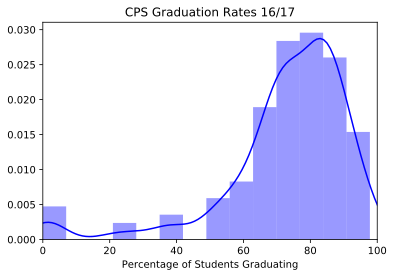

In [6]:
hs_gr_1617 = '''SELECT graduation_rate_school FROM allschools_1617
                                              WHERE is_high_school = 'Y'
                                              AND graduation_rate_school IS NOT NULL'''

cursor.execute(hs_gr_1617)
gr_1617 = [gr[0] for gr in cursor.fetchall()]
sns.distplot(gr_1617, color='b')
plt.xlim(0,100)
plt.xlabel("Percentage of Students Graduating")
plt.title('CPS Graduation Rates 16/17')

Text(0.5, 1.0, 'CPS Graduation Rates 17/18')

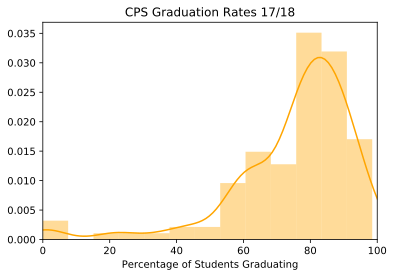

In [7]:
hs_gr_1718 = '''SELECT graduation_rate_school FROM allschools_1718
                                              WHERE is_high_school = 'Y'
                                              AND graduation_rate_school IS NOT NULL'''

cursor.execute(hs_gr_1718)
gr_1718 = [gr[0] for gr in cursor.fetchall()]
sns.distplot(gr_1718, color='orange')
plt.xlim(0, 100)
plt.xlabel("Percentage of Students Graduating")
plt.title('CPS Graduation Rates 17/18')

After superimposing the two histograms, we see increase of grad rates in 2017/18 in comparison to 2016/17

Text(0.5, 1.0, 'HS Grad Rates 16/17 and 17/18')

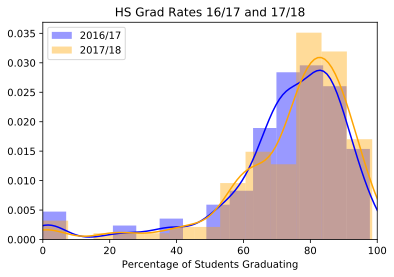

In [8]:
hist_plt = [gr_1617, gr_1718]
color = ['blue', 'orange']
year  = ['2016/17', '2017/18']
for a,c, y in zip(hist_plt, color, year):
    sns.distplot(a, color=c, label=y)
plt.xlim(0,100)
plt.xlabel("Percentage of Students Graduating")
plt.legend()
plt.title("HS Grad Rates 16/17 and 17/18")

In [11]:
print("Skew for 2016/17 school year: %s" %scipy.stats.skew(gr_1617))
print("Skew for 2017/18 school year: %s" %scipy.stats.skew(gr_1718))

Skew for 2016/17 school year: -1.9389214792620162
Skew for 2017/18 school year: -1.94880818014248


Since the graduation rates are both heavily skewed left, they will need to be reflected along the x-axis and log-transformed before regression. See feature engineering notebook for the transformation code. The database has a table with model ready data, which we'll work with from here on out. 

## Log transformed Graduation Rates

In [12]:
query = ('''SELECT * FROM hs_modeldata WHERE log_grad_rate IS NOT NULL''');
df = pd_sql.read_sql(query, conn)

The skew is much reduced with the log-transformed graduation rates.

In [26]:
print("Skew for 2016/17 after log-transformation: %s" 
        %scipy.stats.skew(df[df.school_year=='School Year 2016-2017'].log_grad_rate))
print("Skew for 2017/18 after log-transformation: %s" 
        %scipy.stats.skew(df[df.school_year=='School Year 2017-2018'].log_grad_rate))

Skew for 2016/17 after log-transformation: -0.5025009349240924
Skew for 2017/18 after log-transformation: -0.5371894528156189


Text(0.5, 1.0, 'Log-transformed and reflected\n CPS graduation rates, 2016/17')

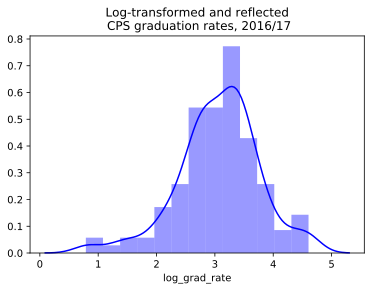

In [33]:
sns.distplot(df[df.school_year=='School Year 2016-2017'].log_grad_rate, color='b')
plt.title('Log-transformed and reflected\n CPS graduation rates, 2016/17')

Text(0.5, 1.0, 'Log-transformed and reflected\n CPS graduation rates, 2017/18')

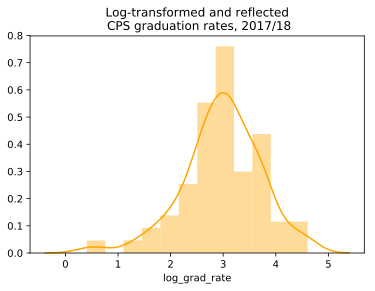

In [34]:
sns.distplot(df[df.school_year=='School Year 2017-2018'].log_grad_rate, color='orange')
plt.title('Log-transformed and reflected\n CPS graduation rates, 2017/18')

Text(0.5, 1.0, 'Log Transformed CPS\n Grad Rates 16/17 and 17/18')

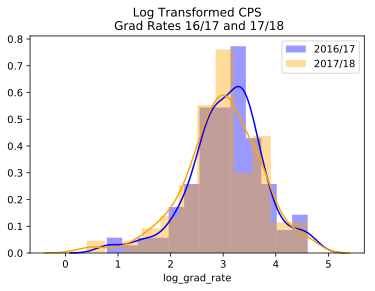

In [35]:
hist_plt_lg = [df[df.school_year=='School Year 2016-2017'].log_grad_rate, 
              df[df.school_year=='School Year 2017-2018'].log_grad_rate]
color = ['blue', 'orange']
year  = ['2016/17', '2017/18']
for a,c, y in zip(hist_plt_lg, color, year):
    sns.distplot(a, color=c, label=y)
plt.legend()
plt.title("Log Transformed CPS\n Grad Rates 16/17 and 17/18")

In [ ]:
Now we will take a look at the features.

## Feature Exploration

In [50]:
demographics = ['student_count_total','student_count_asian',
                'student_count_asian_pacific_islander',
                'student_count_black','student_count_english_learners',
                'student_count_ethnicity_not_available',
                'student_count_hawaiian_pacific_islander', 
                'student_count_hispanic','student_count_low_income', 
                 'student_count_multi','student_count_native_american', 
                 'student_count_other_ethnicity',
                'student_count_special_ed','student_count_white']

for dem in demographics:
    hs_records_1718 = ('''SELECT SUM(%s) FROM allschools_1718
                             WHERE is_high_school = 'Y'
                       ''' %dem)
    cursor = conn.cursor()
    cursor.execute(hs_records_1718)
    print('''There are %s %s students in high schools in the 2017/18 school year'''
              %(cursor.fetchall()[0][0], dem))

# hs_gr_null_1718   = ('''SELECT COUNT(school_id) FROM allschools_1718
#                              WHERE is_high_school = 'Y'
#                              AND graduation_rate_school IS NULL
#                      ''')


There are 112394 student_count_total students in high schools in the 2017/18 school year
There are 4563 student_count_asian students in high schools in the 2017/18 school year
There are 20 student_count_asian_pacific_islander students in high schools in the 2017/18 school year
There are 42768 student_count_black students in high schools in the 2017/18 school year
There are 10893 student_count_english_learners students in high schools in the 2017/18 school year
There are 511 student_count_ethnicity_not_available students in high schools in the 2017/18 school year
There are 176 student_count_hawaiian_pacific_islander students in high schools in the 2017/18 school year
There are 52891 student_count_hispanic students in high schools in the 2017/18 school year
There are 73990 student_count_low_income students in high schools in the 2017/18 school year
There are 1206 student_count_multi students in high schools in the 2017/18 school year
There are 354 student_count_native_american students i

In [37]:
#pairplot is huge, so it is saved as an svg in figures/eda.
#sns.pairplot(df)
#plt.savefig('figures/EDA/pairplot_all.svg')
df_dem_subset = df[['log_grad_rate','student_count_total','student_count_asian_perc',
                'student_count_asian_pacific_islander_perc',
                'student_count_black_perc','student_count_english_learners_perc',
                'student_count_ethnicity_not_available_perc',
                'student_count_hawaiian_pacific_islander_perc', 
                'student_count_hispanic_perc','student_count_low_income_perc', 
                 'student_count_multi_perc','student_count_native_american_perc', 
                 'student_count_other_ethnicity_perc',
                'student_count_special_ed_perc','student_count_white_perc']]
sns.pairplot(df_dem_subset, height=1.2, aspect=1.5);


In [12]:
scipy.stats.skew(df['log_grad_rate'])

-0.5291607698422975

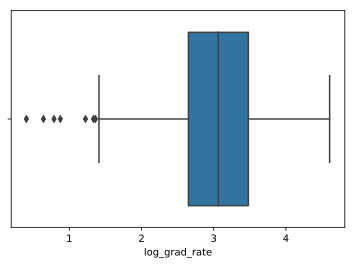

In [13]:
sns.boxplot(df['log_grad_rate'])

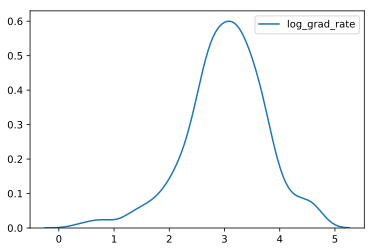

In [14]:
sns.kdeplot(df['log_grad_rate'])

In [16]:
#Try removing outliers outside of 3 STD of the mean.
df['log_grad_rate'].mean()

3.019720043155108

In [17]:
df_remove_outliers = df[(np.abs(df.log_grad_rate-df.log_grad_rate.mean())
                        <= 3*df.log_grad_rate.std())]

In [18]:
df_remove_outliers.head()

school_id            school_year  student_count_total  fully_accessible  \
0     400064  School Year 2016-2017                  388                 1   
1     400105  School Year 2016-2017                  322                 0   
2     609676  School Year 2016-2017                  455                 0   
3     400087  School Year 2016-2017                  198                 0   
4     609764  School Year 2016-2017                 1739                 0   

   generally_accessible  student_count_asian_perc  \
0                     0                     0.010   
1                     0                     0.000   
2                     1                     0.000   
3                     1                     0.000   
4                     1                     0.003   

   student_count_asian_pacific_islander_perc  student_count_black_perc  \
0                                        0.0                     0.869   
1                                        0.0                     0.975   
2                                        0.0                     0.965   
3                                        0.0                     0.924   
4                                        0.0                     0.033   

   student_count_english_learners_perc  \
0                                0.021   
1                                0.000   
2                                0.020   
3                                0.000   
4                                0.190   

   student_count_ethnicity_not_available_perc  \
0                                       0.000   
1                                       0.000   
2                                       0.000   
3                                       0.000   
4                                       0.006   

   student_count_hawaiian_pacific_islander_perc  student_count_hispanic_perc  \
0                                         0.005                        0.101   
1                                         0.000                        0.012   
2                                         0.000                        0.033   
3                                         0.000                        0.045   
4                                         0.000                        0.945   

   student_count_low_income_perc  student_count_multi_perc  \
0                          0.863                     0.010   
1                          0.814                     0.009   
2                          0.965                     0.000   
3                          0.924                     0.010   
4                          0.954                     0.002   

   student_count_native_american_perc  student_count_other_ethnicity_perc  \
0                               0.000                                 0.0   
1                               0.003                                 0.0   
2                               0.002                                 0.0   
3                               0.000                                 0.0   
4                               0.003                                 0.0   

   student_count_special_ed_perc  student_count_white_perc  \
0                          0.193                     0.005   
1                          0.193                     0.000   
2                          0.273                     0.000   
3                          0.313                     0.020   
4                          0.162                     0.007   

   classroom_langauges_count  blue  brown  green  orange  pink  purple  red  \
0                          1     0      0      1       0     0       0    1   
1                          2     0      0      1       0     0       0    1   
2                          2     0      0      0       0     0       0    0   
3                          1     0      0      0       0     0       0    1   
4                          2     1      0      0       0     1       0    1   

   dress_code_dummie  grades_offered_count  charter  gend

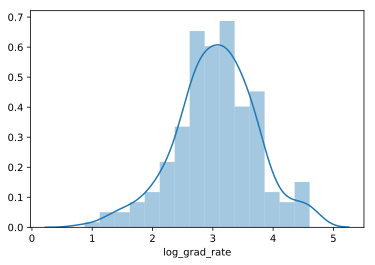

In [19]:
sns.distplot(df_remove_outliers['log_grad_rate'])

In [20]:
df_remove_outliers_2std = df[(np.abs(df.log_grad_rate-df.log_grad_rate.mean())
                        <= 2*df.log_grad_rate.std())]

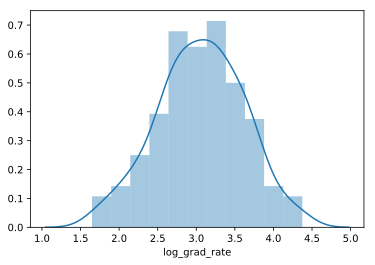

In [21]:
sns.distplot(df_remove_outliers_2std['log_grad_rate'])

## Correlation

In [22]:
df.corr()

school_id  student_count_total  \
school_id                                         1.000                0.156   
student_count_total                               0.156                1.000   
fully_accessible                                  0.088               -0.021   
generally_accessible                              0.006                0.125   
student_count_asian_perc                          0.144                0.451   
student_count_asian_pacific_islander_perc         0.019                0.191   
student_count_black_perc                         -0.176               -0.440   
student_count_english_learners_perc               0.144               -0.013   
student_count_ethnicity_not_available_perc       -0.050                0.203   
student_count_hawaiian_pacific_islander_perc      0.151                0.276   
student_count_hispanic_perc                       0.110                0.255   
student_count_low_income_perc                    -0.081               -0.396   
...                                                 ...                  ...   
green                                            -0.106               -0.246   
orange                                            0.008                0.279   
pink                                             -0.077                0.058   
purple                                           -0.018                0.167   
red                                              -0.028               -0.034   
dress_code_dummie                                -0.385               -0.331   
grades_offered_count                             -0.237                0.137   
charter                                          -0.950               -0.136   
gender_f_bn                                      -0.168               -0.182   
log_grad_rate                                     0.057               -0.451   
zip                                               0.121                0.013   
zip_mean_income                                  -0.022                0.370   

                                              fully_accessible  \
school_id                                                0.088   
student_count_total                                     -0.021   
fully_accessible                                         1.000   
generally_accessible                                    -0.658   
student_count_asian_perc                                 0.185   
student_count_asian_pacific_islander_perc                0.169   
student_count_black_perc                                -0.223   
student_count_english_learners_perc                      0.129   
student_count_ethnicity_not_available_perc               0.103   
student_count_hawaiian_pacific_islander_perc             0.083   
student_count_hispanic_perc                              0.186   
student_count_low_income_perc                           -0.051   
...                                                        ...   
green                                                   -0.013   
orange                                                   0.123   
pink                                                    -0.053   
purple                                                   0.019   
red                                                     -0.062   
dress_code_dummie                                       -0.081   
grades_offered_count                                     0.001   
charter                                                 -0.102   
gender_f_bn                                             -0.134   
log_grad_rate                                           -0.154   
zip                                                      0.069   
zip_mean_income                                          0.037   

                                              generally_accessible  \
school_id                                                    0.006   
student_count_total                                          0.125   
fully_accessible                      

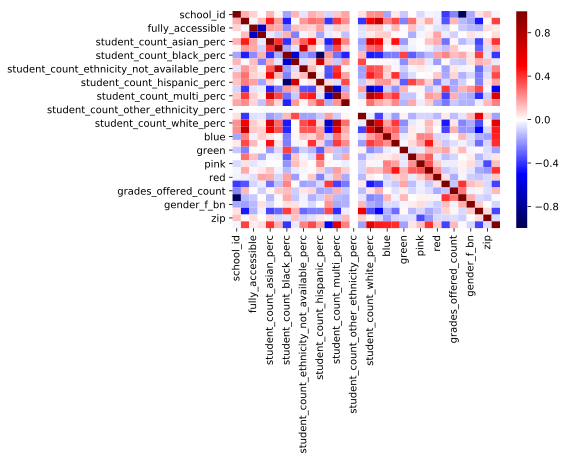

In [23]:
# example of a better corr matrix
sns.heatmap(df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);